#### Обработка данных

In [1]:
import pandas as pd
import numpy as np
from math import *

import plotly.plotly as py
import plotly.graph_objs as go

from sklearn import cross_validation, linear_model, metrics

from scipy import optimize as opt

import statsmodels.stats.api as sms

import scipy.odr as odr

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/heyfaraday/anaconda/envs/new2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['cosh', 'ldexp', 'hypot', 'tan', 'isnan', 'log', 'fabs', 'floor', 'sqrt', 'frexp', 'degrees', 'pi', 'log10', 'sin', 'modf', 'copysign', 'cos', 'ceil', 'isinf', 'sinh', 'trunc', 'expm1', 'e', 'tanh', 'radians', 'fmod', 'exp', 'log1p', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy



In [2]:
data = pd.read_csv('experiment.csv') # Считываем данные

In [3]:
print data.head(5) # Посмотрим на несколько значений

   index  feature1  feature2
0      1      0.07      0.27
1      2      0.12      0.35
2      3      0.20      0.45
3      4      0.27      0.52
4      5      0.32      0.57


Сгенерируем новые признаки и значения измерений, вычислим ошибки и определимся с размерностями в данных

$d = 0.16 \ cm$

$sigma_d^{syst} = 0.01 \ cm$

$s = 42 \ cm^2$

$sigma_s^{syst} = 1 \ cm^2$

$\epsilon^{syst}_m = 0.03 $

$sigma^{syst}_u = 0.02 \ kV$

feature1 = $m, \ g$

feature2 = $U_{isu}, \ B$

feature3 = $F, \ N$ = feature1 $\cdot 10^{-2}$

feature4 = $U_{isu}^2, \ B^2$

feature5 = $2 d \sqrt{\frac{2 \pi F}{S}}, \ g^{1/2} {cm}^{1/2} s^{-1} \ = \ U_{cgs}$

feature6 = $\sigma_F^{syst} \ = \ 0.03 \cdot feature3$ 

feature7 = $\sigma_{U^2}^{syst} \ = \ 2U \sigma^{syst}_u $

feature8 = $\sigma_{U_{cgs}}^{syst}$

In [4]:
d = 0.16 
sigma_syst_d = 0.01
s = 42 
sigma_syst_s = 1
epsilon_syst_m = 0.03
sigma_syst_u = 0.02

In [5]:
data['feature2'] = data['feature2']*1000

In [6]:
data.insert(3, 'feature3', data['feature1']*0.01)

In [7]:
data.insert(4, 'feature4', data['feature2']*data['feature2'])

In [8]:
print data.head(5)

   index  feature1  feature2  feature3  feature4
0      1      0.07       270    0.0007     72900
1      2      0.12       350    0.0012    122500
2      3      0.20       450    0.0020    202500
3      4      0.27       520    0.0027    270400
4      5      0.32       570    0.0032    324900


In [9]:
data.insert(5, 'feature5', data['feature3'].apply(np.sqrt)*2*d*sqrt(2*pi/s*100000))

In [10]:
data.insert(6, 'feature6', data['feature3']*epsilon_syst_m)

In [11]:
data.insert(7, 'feature7', sigma_syst_u*1000 * 2 * data['feature2'])

In [12]:
data.insert(8, 'feature8', data['feature5']*(1/d*sigma_syst_d + 1/(data['feature3']+s)*0.5))

In [13]:
data.insert(9, 'empty', 1)

In [14]:
data_e = data[8:10]

In [15]:
data_e['index'] = [1, 2]

/Users/heyfaraday/anaconda/envs/new2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [16]:
data = data.drop([9,8])

In [17]:
print data

    index  feature1  feature2  feature3  feature4  feature5  feature6  \
0       1      0.07       270    0.0007     72900  1.035534  0.000021   
1       2      0.12       350    0.0012    122500  1.355832  0.000036   
2       3      0.20       450    0.0020    202500  1.750372  0.000060   
3       4      0.27       520    0.0027    270400  2.033748  0.000081   
4       5      0.32       570    0.0032    324900  2.214064  0.000096   
5       6      0.37       610    0.0037    372100  2.380763  0.000111   
6       7      0.42       650    0.0042    422500  2.536529  0.000126   
7       8      0.47       710    0.0047    504100  2.683269  0.000141   
10     11      0.17       380    0.0017    144400  1.613763  0.000051   
11     12      0.65       770    0.0065    592900  3.155527  0.000195   
12     13      0.55       750    0.0055    562500  2.902663  0.000165   

    feature7  feature8  empty  
0      10800  0.077048      1  
1      14000  0.100880      1  
2      18000  0.130235     

#### Визуализация и информация о данных

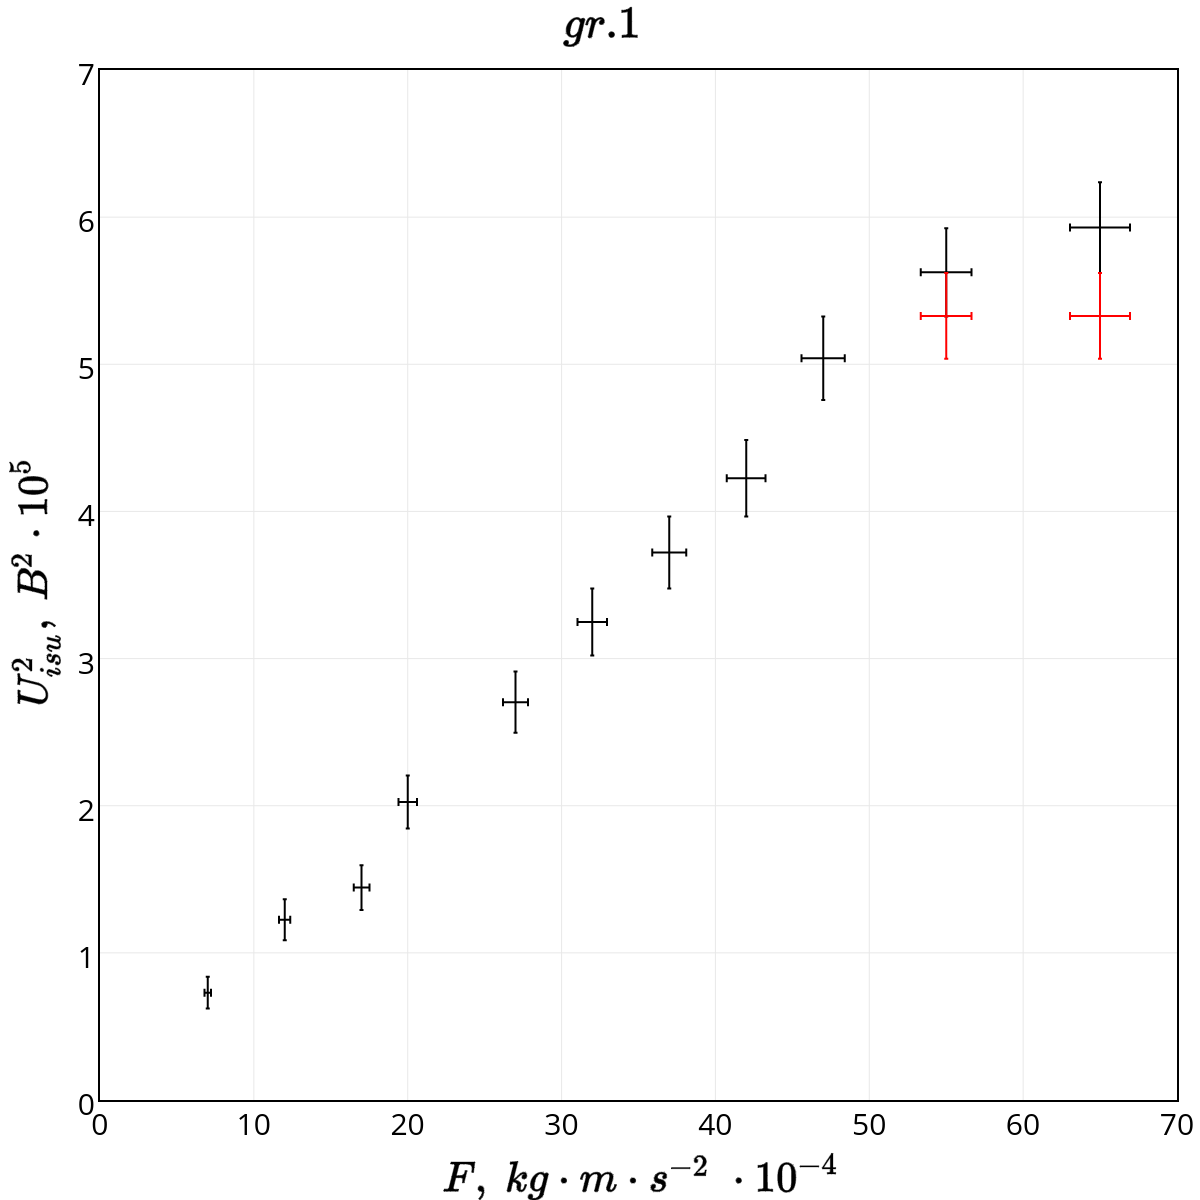

In [20]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter(
    x = data['feature3']*10000,
    y = data['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data['feature7']/100000,
        visible = True,
        color = '#000000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data['feature6']*10000,
        visible = True,
        color = '#000000'
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#000000'
    )
)
trace2 = go.Scatter(
    x = data_e['feature3']*10000,
    y = data_e['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data_e['feature7']/100000,
        visible = True,
        color = '#ff0000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data_e['feature6']*10000,
        visible = True,
        color = '#ff0000',
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#ff0000'
    )
)

trace0 = [trace1, trace2]

layout = go.Layout(
    title = "$gr.1$",
    width = 1200,
    height = 1200,
    font = dict(
        size = 30,
        color = '#000000'
        ),
    showlegend=False,
    paper_bgcolor = '#ffffff',
    xaxis = dict(
        title = '$F,~kg \cdot m \cdot s^{-2}~\cdot 10^{-4}$',
        range = [0, 70],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    yaxis = dict(
        title = '$U_{isu}^2,~B^2 \cdot 10^5$',
        range = [0, 7],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    margin = dict(
        l = 100,
        r = 23,
        t = 70,
        b = 100,
        pad = 0 
    )
    
)

fig = go.Figure(data=trace0, layout=layout)
#py.iplot(figure, filename='basic-error-bar')
py.image.save_as(fig, 'my_plot.png')
#! open my_plot.png
from IPython.display import Image
Image("my_plot.png")

#### Анализ

#### Curve fit (without sigma)

In [21]:
X = np.reshape(np.array(data['feature3']), (1, len(np.array(data['feature3']))))
Y = np.reshape(np.array(data['feature4']), (1, len(np.array(data['feature4']))))

In [22]:
def f(x, b):
    return b*x
parameters_opt, parameters_cov = opt.curve_fit(f, X[0], Y[0])

In [23]:
print("y  = ({:.3f})*x".format(parameters_opt[0]))
print("(+-)({:.3f})*x".format(np.sqrt(np.diag(parameters_cov))[0]))

y  = (99076705.798)*x
(+-)(1840983.209)*x


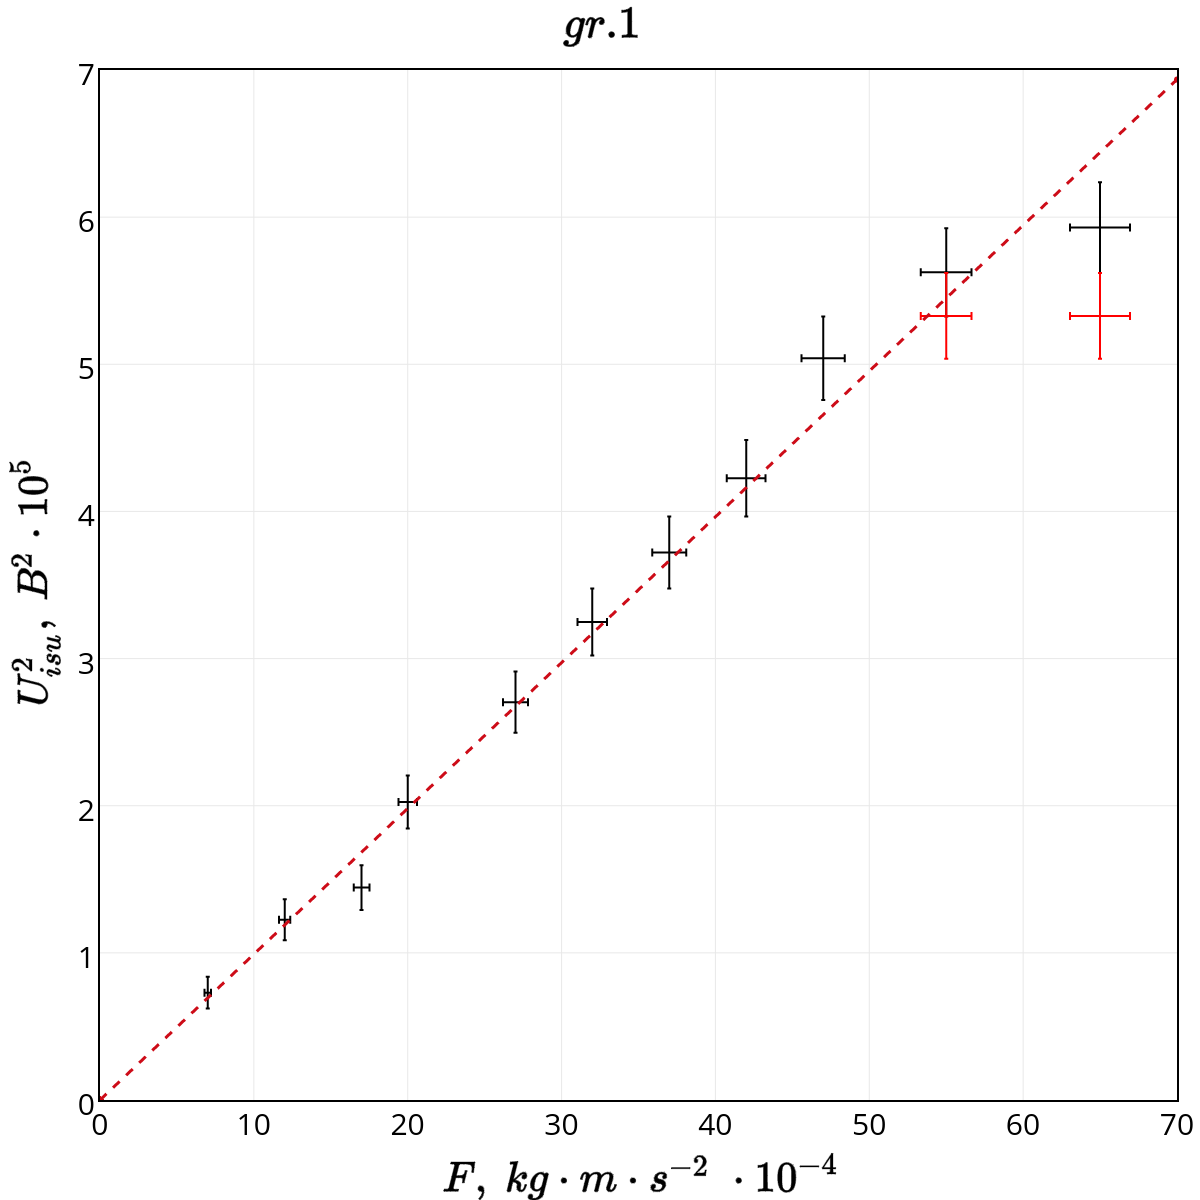

In [24]:
trace3 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.0001, 0.0007*99076705.798*0.0001],
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 3,
        dash = 'dash')
)

trace4 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(99076705.798-1840983.209)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace5 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(99076705.798+1840983.209)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace6 = go.Scatter(
    x = [0.0*10000.0, 0.0007*10000.0],
    y = [0.0*0.00001, 0.0007*(99076705.798-2*1840983.209)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 2,
        dash = 'dash')
)

trace7 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(99076705.798+2*1840983.209)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 2,
        dash = 'dash')
)


trace1 = go.Scatter(
    x = data['feature3']*10000,
    y = data['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data['feature7']/100000,
        visible = True,
        color = '#000000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data['feature6']*10000,
        visible = True,
        color = '#000000'
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#000000'
    )
)
trace2 = go.Scatter(
    x = data_e['feature3']*10000,
    y = data_e['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data_e['feature7']/100000,
        visible = True,
        color = '#ff0000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data_e['feature6']*10000,
        visible = True,
        color = '#ff0000',
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#ff0000'
    )
)

trace0 = [trace1, trace2, trace3] #, trace4, trace5, trace6, trace7]

layout = go.Layout(
    title = "$gr.1$",
    width = 1200,
    height = 1200,
    font = dict(
        size = 30,
        color = '#000000'
        ),
    showlegend=False,
    paper_bgcolor = '#ffffff',
    xaxis = dict(
        title = '$F,~kg \cdot m \cdot s^{-2}~\cdot 10^{-4}$',
        range = [0, 70],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    yaxis = dict(
        title = '$U_{isu}^2,~B^2 \cdot 10^5$',
        range = [0, 7],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    margin = dict(
        l = 100,
        r = 23,
        t = 70,
        b = 100,
        pad = 0 
    )
    
)

fig = go.Figure(data=trace0, layout=layout)
#py.iplot(figure, filename='basic-error-bar')
py.image.save_as(fig, 'my_plot1.png')
#! open my_plot.png
from IPython.display import Image
Image("my_plot1.png")

In [25]:
err = pd.DataFrame()
err.insert(0, '0', data['feature4']-99076705.798*data['feature3'])
err.insert(1, '1', data['feature3'])

In [26]:
print err['0']

0      3546.305941
1      3607.953042
2      4346.588404
3      2892.894345
4      7854.541446
5      5516.188547
6      6377.835648
7     38439.482749
10   -24030.399857
11   -51098.587687
12    17578.118111
Name: 0, dtype: float64


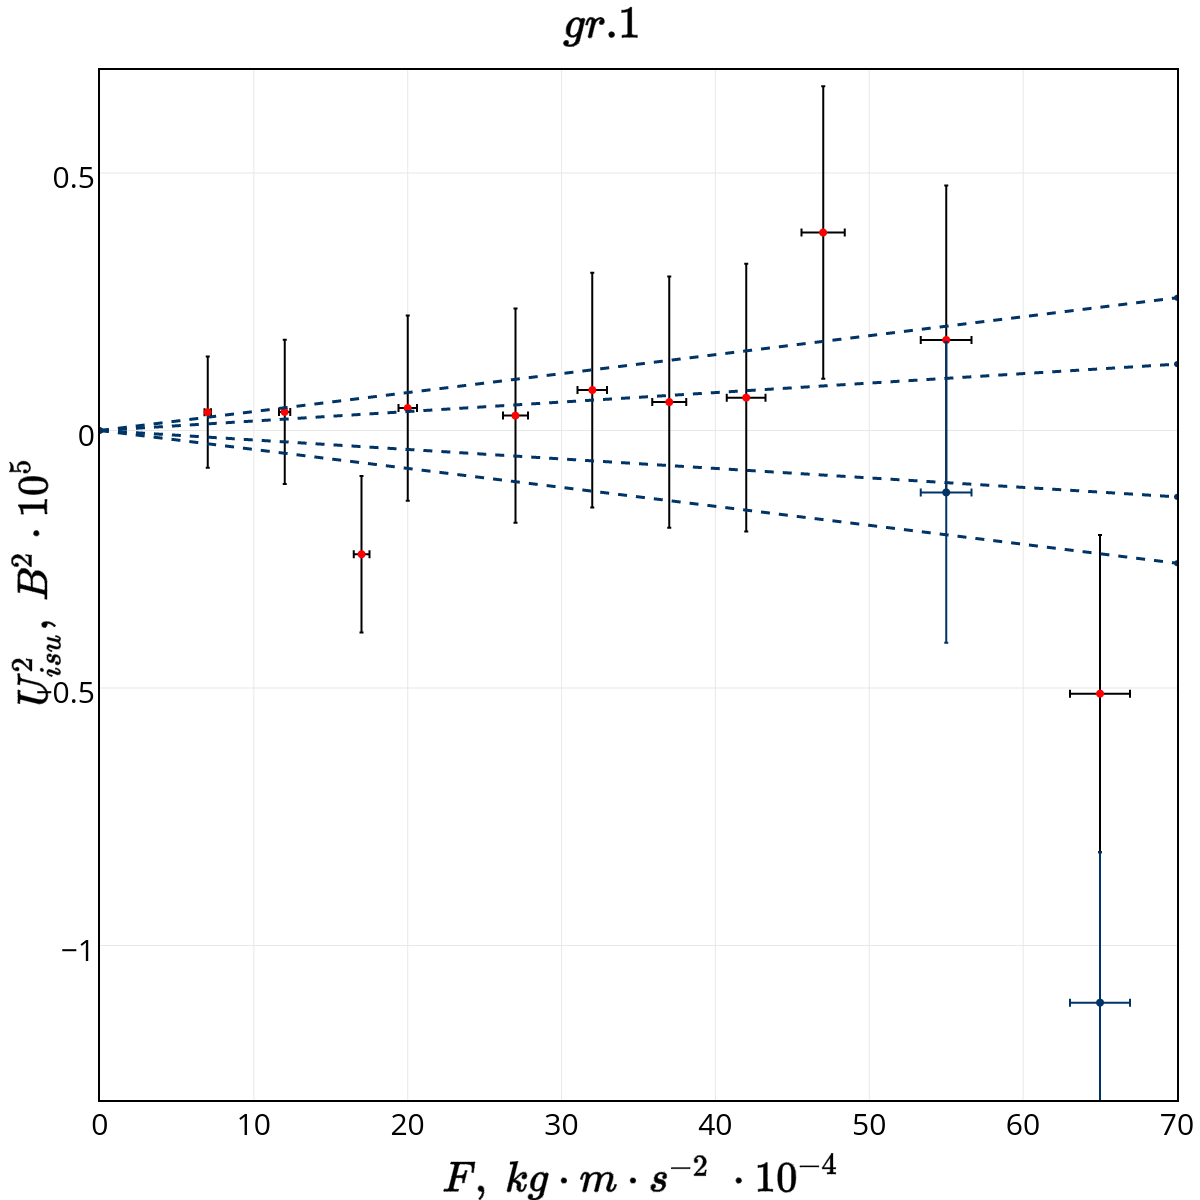

In [98]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter(
    x = err['1']*10000,
    y = err['0']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data['feature7']/100000,
        visible = True,
        color = '#000000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data['feature6']*10000,
        visible = True,
        color = '#000000'
    ),
    marker = dict(
        size = 8,
        opacity = 1,
        color = '#ff0000'
    )
)

trace2 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*1840983.209*0.0001],
    line = dict(
        color = ('#003366'),#51d9c5
        width = 3,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, -0.0007*1840983.209*0.0001],
    line = dict(
        color = ('#003366'),#51d9c5
        width = 3,
        dash = 'dash')
)

trace4 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, -2*0.0007*1840983.209*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace5 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 2*0.0007*1840983.209*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace6 = go.Scatter(
    x = data_e['feature3']*10000,
    y = (data_e['feature4']-99076705.798*data_e['feature3'])/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data_e['feature7']/100000,
        visible = True,
        color = '#003366',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data_e['feature6']*10000,
        visible = True,
        color = '#003366',
    ),
    marker = dict(
        size = 8,
        opacity = 1,
        color = '#003366'
    )
)


trace0 = [trace1, trace2, trace3, trace4, trace5, trace6]

layout = go.Layout(
    title = "$gr.1$",
    width = 1200,
    height = 1200,
    font = dict(
        size = 30,
        color = '#000000'
        ),
    showlegend=False,
    paper_bgcolor = '#ffffff',
    xaxis = dict(
        title = '$F,~kg \cdot m \cdot s^{-2}~\cdot 10^{-4}$',
        range = [0, 70],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    yaxis = dict(
        title = '$U_{isu}^2,~B^2 \cdot 10^5$',
        range = [-1.3, 0.7],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    margin = dict(
        l = 100,
        r = 23,
        t = 70,
        b = 100,
        pad = 0 
    )
    
)

fig = go.Figure(data=trace0, layout=layout)
#py.iplot(figure, filename='basic-error-bar')
py.image.save_as(fig, 'my_plot2.png')
#! open my_plot.png
from IPython.display import Image
Image("my_plot2.png")

In [ ]:
err

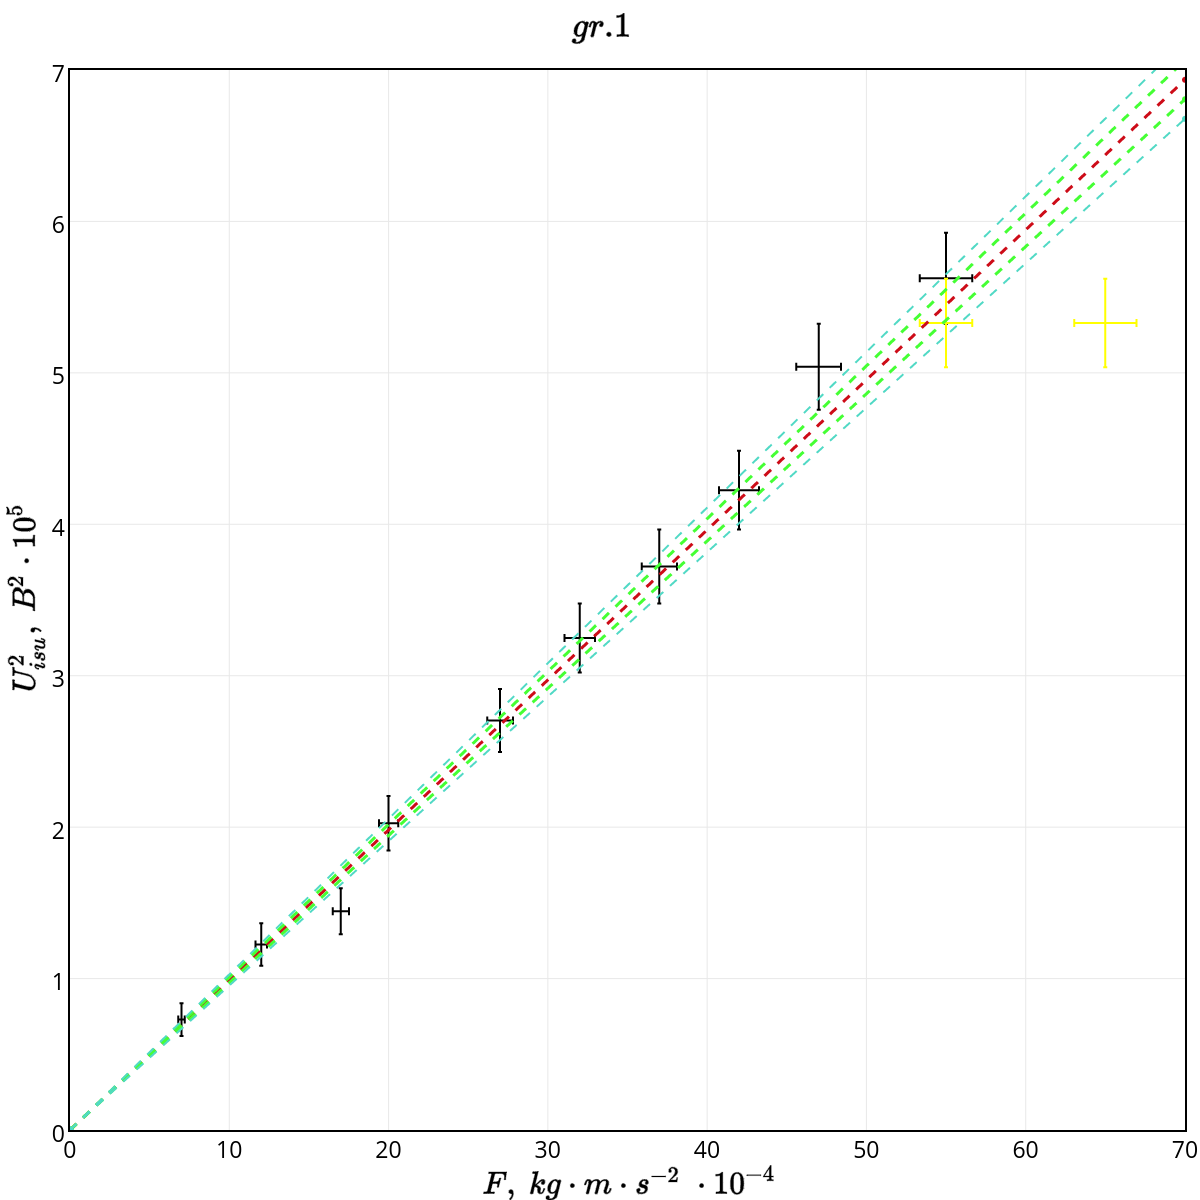

In [49]:
trace3 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.0001, 0.0007*99076705.798*0.0001],
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 3,
        dash = 'dash')
)

trace4 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(99076705.798-1840983.209)*0.0001],
    line = dict(
        color = ('#45ff34'),
        width = 3,
        dash = 'dash')
)

trace5 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(99076705.798+1840983.209)*0.0001],
    line = dict(
        color = ('#45ff34'),
        width = 3,
        dash = 'dash')
)

trace6 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(99076705.798-2*1840983.209)*0.0001],
    line = dict(
        color = ('#51d9c5'),
        width = 2,
        dash = 'dash')
)

trace7 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(99076705.798+2*1840983.209)*0.0001],
    line = dict(
        color = ('#51d9c5'),
        width = 2,
        dash = 'dash')
)


trace1 = go.Scatter(
    x = data['feature3']*10000,
    y = data['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data['feature7']/100000,
        visible = True,
        color = '#000000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data['feature6']*10000,
        visible = True,
        color = '#000000'
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#000000'
    )
)
trace2 = go.Scatter(
    x = data_e['feature3']*10000,
    y = data_e['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data_e['feature7']/100000,
        visible = True,
        color = '#FFFF00',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data_e['feature6']*10000,
        visible = True,
        color = '#FFFF00',
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#FFFF00'
    )
)

trace0 = [trace1, trace2, trace3, trace4, trace5, trace6, trace7]

layout = go.Layout(
    title = "$gr.1$",
    width = 1200,
    height = 1200,
    font = dict(
        size = 23,
        color = '#000000'
        ),
    showlegend=False,
    paper_bgcolor = '#ffffff',
    xaxis = dict(
        title = '$F,~kg \cdot m \cdot s^{-2}~\cdot 10^{-4}$',
        range = [0, 70],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 30,
            color = '#000000' 
            )
    ),
    yaxis = dict(
        title = '$U_{isu}^2,~B^2 \cdot 10^5$',
        range = [0, 7],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 30,
            color = '#000000' 
            )
    ),
    margin = dict(
        l = 70,
        r = 15,
        t = 70,
        b = 70,
        pad = 0 
    )
    
)

fig = go.Figure(data=trace0, layout=layout)
#py.iplot(figure, filename='basic-error-bar')
py.image.save_as(fig, 'my_plot1.png')
#! open my_plot.png
from IPython.display import Image
Image("my_plot1.png")

In [50]:
data = data.drop([11])
err = err.drop([11])

Ошибка для электрической постоянной:

In [51]:
e = 2*(d*d)/(s*parameters_opt[0])
print e

1.23040790389e-11


In [52]:
sigma_syst_e = 2*e*sigma_syst_d/d + e*sigma_syst_s/s
sigma_stat_e = (np.sqrt(np.diag(parameters_cov))[0])/parameters_opt[0] * e
print (sigma_syst_e)
print (sigma_stat_e)
sigma_e = sqrt(sigma_syst_e*sigma_syst_e + sigma_stat_e*sigma_stat_e)
print sigma_e*10**12

1.83096414269e-12
2.28626928357e-13
1.84518290806


t-критерий Стьюдента, но уже без последнего измерения:

In [53]:
from statsmodels.stats.weightstats import *
import scipy

In [54]:
print scipy.stats.ttest_1samp(err['0'], 0.0)
print zconfint(err['0'])

Ttest_1sampResult(statistic=1.3649909836992549, pvalue=0.20540232149896795)
(-2882.4565520476908, 16108.358227887697)


In [57]:
print err

               0       1
0    3546.305941  0.0007
1    3607.953042  0.0012
2    4346.588404  0.0020
3    2892.894345  0.0027
4    7854.541446  0.0032
5    5516.188547  0.0037
6    6377.835648  0.0042
7   38439.482749  0.0047
10 -24030.399857  0.0017
12  17578.118111  0.0055


In [58]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % scipy.stats.shapiro(err['0'])

Shapiro-Wilk normality test, W-statistic: 0.834333, p-value: 0.037729


In [60]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % scipy.stats.shapiro([3546.305941, 3607.953042, 
                                                                                         4346.588404, 2892.894345, 
                                                                                         7854.541446, 5516.188547, 
                                                                                         6377.835648])

Shapiro-Wilk normality test, W-statistic: 0.930643, p-value: 0.556384


In [ ]:
err['0']*data['feature7'].apply(np.reciprocal)

In [ ]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % scipy.stats.shapiro([0.328362, 0.257711 ,0.241477, 
                                                                                         0.139081, 0.344497, 0.226073,
                                                                                         0.245301])

In [67]:
err1 = err.drop([10])
err1 = err1.drop([12])
err1 = err1.drop([7])

print err1

data1 = data.drop([10])
data1 = data1.drop([12])
data1 = data1.drop([7])

print data1

             0       1
0  3546.305941  0.0007
1  3607.953042  0.0012
2  4346.588404  0.0020
3  2892.894345  0.0027
4  7854.541446  0.0032
5  5516.188547  0.0037
6  6377.835648  0.0042
   index  feature1  feature2  feature3  feature4  feature5  feature6  \
0      1      0.07       270    0.0007     72900  1.035534  0.000021   
1      2      0.12       350    0.0012    122500  1.355832  0.000036   
2      3      0.20       450    0.0020    202500  1.750372  0.000060   
3      4      0.27       520    0.0027    270400  2.033748  0.000081   
4      5      0.32       570    0.0032    324900  2.214064  0.000096   
5      6      0.37       610    0.0037    372100  2.380763  0.000111   
6      7      0.42       650    0.0042    422500  2.536529  0.000126   

   feature7  feature8  empty  
0     10800  0.077048      1  
1     14000  0.100880      1  
2     18000  0.130235      1  
3     20800  0.151319      1  
4     22800  0.164735      1  
5     24400  0.177138      1  
6     26000  0.188727 

#### Построение моделей


In [109]:
X = np.reshape(np.array(data['feature3']), (1, len(np.array(data['feature3']))))
Y = np.reshape(np.array(data['feature4']), (1, len(np.array(data['feature4']))))
Xerr = np.reshape(np.array(data['feature6']), (1, len(np.array(data['feature6']))))
Yerr = np.reshape(np.array(data['feature7']), (1, len(np.array(data['feature7']))))
def f(x, b):
    return b*x
parameters_opt, parameters_cov = opt.curve_fit(f, X[0], Y[0]) #, sigma = Yerr[0], absolute_sigma=True)
print("y  = ({:.3f})*x".format(parameters_opt[0]))
print("(+-)({:.3f})*x".format(np.sqrt(np.diag(parameters_cov))[0]))
sigma_syst_e = 2*e*sigma_syst_d/d + e*sigma_syst_s/s
sigma_stat_e = (np.sqrt(np.diag(parameters_cov))[0])/parameters_opt[0] * e
print (sigma_syst_e)
print (sigma_stat_e)
sigma_e = sqrt(sigma_syst_e*sigma_syst_e + sigma_stat_e*sigma_stat_e)
print sigma_e*10**12

y  = (99076705.798)*x
(+-)(1840983.209)*x
1.83096414269e-12
2.28626928357e-13
1.84518290806


In [110]:
def f(x, b):
    return b*x
parameters_opt, parameters_cov = opt.curve_fit(f, X[0], Y[0], sigma = Yerr['0'], absolute_sigma=False)
print("y  = ({:.3f})*x".format(parameters_opt[0]))
print("(+-)({:.3f})*x".format(np.sqrt(np.diag(parameters_cov))[0]))
sigma_syst_e = 2*e*sigma_syst_d/d + e*sigma_syst_s/s
sigma_stat_e = (np.sqrt(np.diag(parameters_cov))[0])/parameters_opt[0] * e
print (sigma_syst_e)
print (sigma_stat_e)
sigma_e = sqrt(sigma_syst_e*sigma_syst_e + sigma_stat_e*sigma_stat_e)
print sigma_e*10**12

y  = (99142582.544)*x
(+-)(1864100.538)*x
1.83096414269e-12
2.31343987267e-13
1.84552153394


/Users/heyfaraday/anaconda/envs/new2/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



In [113]:
def linear_func(b, x):
     return b[0]*x

linear_model = odr.Model(linear_func)

data = odr.RealData(X, Y, sx=Xerr, sy=Yerr)

my_odr = odr.ODR(data, linear_model, beta0=[99000000])

out = my_odr.run()

out.pprint()

Beta: [ 99334971.28596886]
Beta Std Error: [ 1859670.57115735]
Beta Covariance: [[  5.41928371e+12]]
Residual Variance: 0.63816083837
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


In [114]:
X = np.reshape(np.array(data1['feature3']), (1, len(np.array(data1['feature3']))))
Y = np.reshape(np.array(data1['feature4']), (1, len(np.array(data1['feature4']))))
Xerr = np.reshape(np.array(data1['feature6']), (1, len(np.array(data1['feature6']))))
Yerr = np.reshape(np.array(data1['feature7']), (1, len(np.array(data1['feature7']))))
def f(x, b):
    return b*x
parameters_opt, parameters_cov = opt.curve_fit(f, X[0], Y[0]) #, sigma = Yerr[0], absolute_sigma=True)
print("y  = ({:.3f})*x".format(parameters_opt[0]))
print("(+-)({:.3f})*x".format(np.sqrt(np.diag(parameters_cov))[0]))
sigma_syst_e = 2*e*sigma_syst_d/d + e*sigma_syst_s/s
sigma_stat_e = (np.sqrt(np.diag(parameters_cov))[0])/parameters_opt[0] * e
print (sigma_syst_e)
print (sigma_stat_e)
sigma_e = sqrt(sigma_syst_e*sigma_syst_e + sigma_stat_e*sigma_stat_e)
print sigma_e*10**12

y  = (100822412.811)*x
(+-)(238389.050)*x
0.404506224473
0.00642722789131
404557282589.0


In [115]:
def f(x, b):
    return b*x
parameters_opt, parameters_cov = opt.curve_fit(f, X[0], Y[0], sigma = Yerr['0'], absolute_sigma=False)
print("y  = ({:.3f})*x".format(parameters_opt[0]))
print("(+-)({:.3f})*x".format(np.sqrt(np.diag(parameters_cov))[0]))
sigma_syst_e = 2*e*sigma_syst_d/d + e*sigma_syst_s/s
sigma_stat_e = (np.sqrt(np.diag(parameters_cov))[0])/parameters_opt[0] * e
print (sigma_syst_e)
print (sigma_stat_e)
sigma_e = sqrt(sigma_syst_e*sigma_syst_e + sigma_stat_e*sigma_stat_e)
print sigma_e*10**12

y  = (100998666.595)*x
(+-)(342852.247)*x
0.404506224473
0.00922753799042
404611459421.0


/Users/heyfaraday/anaconda/envs/new2/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



In [116]:
def linear_func(b, x):
     return b[0]*x

linear_model = odr.Model(linear_func)

data = odr.RealData(X, Y, sx=Xerr, sy=Yerr)

my_odr = odr.ODR(data, linear_model, beta0=[99000000])

out = my_odr.run()

out.pprint()

Beta: [  1.01028915e+08]
Beta Std Error: [ 356048.61642728]
Beta Covariance: [[  1.07215695e+13]]
Residual Variance: 0.0118238862053
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


In [119]:
answer =  (99076705.798 + 99142582.544 + 99334971 + 100822412.811 + 100998666.595 + 1.01028915e+08)/6
print answer

100067375.625


In [120]:
e = 2*(d*d)/(s*answer)
print e

1.21822683111e-11
